In [56]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image as Image

In [57]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #pre-trained model accepts (224,224,3) image

In [58]:
imS = (224,224)
C = tf.keras.Sequential([
    hub.KerasLayer(classifier_url,input_shape=imS+(3,))
])

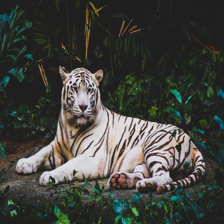

In [59]:
I = Image.open(r'/home/rahul/WSL_Projects/ReferencesPython/Convolutional Neural Networks/TransferLearningTF/tiger.jpg').resize(imS)
I

In [60]:
I = np.array(I)/255.0
I.shape

(224, 224, 3)

In [61]:
r = C.predict(I[np.newaxis,...])
r.shape,r #none of the classes is 1001

1/1 [==============================] - 1s 1s/step


((1, 1001),
 array([[ 0.24926761,  0.3770399 , -0.1862553 , ..., -0.16846824,
         -0.7609773 ,  1.6861752 ]], dtype=float32))

In [62]:
pc = np.argmax(r[0],axis=-1)
pc #predicted class

293

In [63]:
#get image labels based on the classes available
lp = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imnet_labels = np.array(open(lp).read().splitlines())

Text(0.5, 1.0, 'tiger')

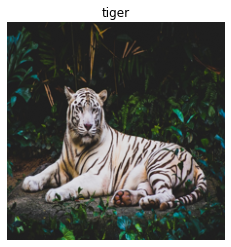

In [64]:
plt.imshow(I)
plt.axis('off')
pcn = imnet_labels[pc]
plt.title(pcn) #the classification was correct

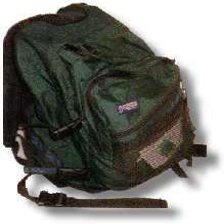

In [65]:
I = Image.open(r'/home/rahul/WSL_Projects/ReferencesPython/Convolutional Neural Networks/TransferLearningTF/Calteck_DataSet_256_ObjectCategories/003.backpack/003_0003.jpg').resize(imS)
I

In [66]:
I = np.array(I)/255.0
I.shape

(224, 224, 3)

In [67]:
r = C.predict(I[np.newaxis,...])
r.shape

1/1 [==============================] - 0s 84ms/step


(1, 1001)

In [68]:
pc = np.argmax(r[0],axis=-1)
pc

415

Text(0.5, 1.0, 'backpack')

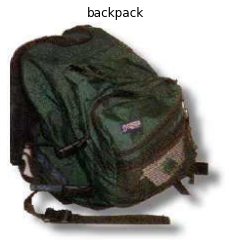

In [69]:
plt.imshow(I)
plt.axis('off')
pcn = imnet_labels[pc]
plt.title(pcn)

## Lets use transfer learning on the model

In [70]:
data_root = tf.keras.utils.get_file(
'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
untar=True)

In [71]:
ig = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255) #normalise
imData = ig.flow_from_directory(str(data_root),target_size=imS) #reshape to match model input

Found 3670 images belonging to 5 classes.


In [72]:
for imB,lbB in imData:
    print(imB.shape) #32 images per batch 224x224x3
    print(lbB.shape) #32 images has 5 classes
    break

(32, 224, 224, 3)
(32, 5)


In [73]:
rB = C.predict(imB) #32 images with prob distribution over classes
rB.shape

1/1 [==============================] - 1s 614ms/step


(32, 1001)

In [74]:
pcn = imnet_labels[np.argmax(rB,axis=-1)] #predicted class names
pcn

array(['feather boa', 'bee', 'daisy', 'bee', 'wool', 'pretzel',
       'coral fungus', 'swing', 'cardoon', 'cardoon', 'picket fence',
       'umbrella', 'chime', 'daisy', 'daisy', 'conch', 'mask',
       'Bedlington terrier', 'pot', 'vase', 'picket fence',
       'picket fence', 'pot', 'balloon', 'hip', 'bakery', 'daisy', 'pot',
       'daisy', 'picket fence', 'ant', 'daisy'], dtype='<U30')

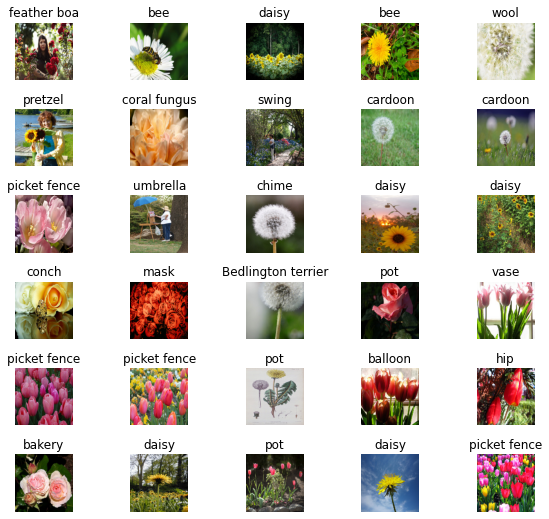

In [75]:
#label images with current model predictions for class names
plt.figure(figsize=(10,9)) #notice our current model is not trained to identify flowers
plt.subplots_adjust(hspace=0.5) #predicting them inaccurately
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(imB[i])
    plt.title(pcn[i])
    plt.axis('off')

In [76]:
# classifier without head
headLessModel_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

In [77]:
imS, imS+(3,) #RGB 

((224, 224), (224, 224, 3))

In [78]:
headLessModel = hub.KerasLayer(headLessModel_url,input_shape=imS+(3,))

In [79]:
fImB = headLessModel(imB) #feature extractor
fImB.shape

TensorShape([32, 1280])

In [80]:
headLessModel.trainable = False #freeze the weights

In [81]:
imData.num_classes

5

In [82]:
newModel = tf.keras.Sequential([
    headLessModel, #mobile net v2
    tf.keras.layers.Dense(imData.num_classes,activation='softmax')#5 classes
])

In [83]:
newModel.compile(
optimizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
metrics=['acc'])

In [84]:
newModel.fit(imData,epochs=10) #train with our own model

Epoch 1/10


/usr/lib/python3/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


115/115 [==============================] - 23s 136ms/step - loss: 0.6918 - acc: 0.7507
Epoch 2/10
115/115 [==============================] - 11s 88ms/step - loss: 0.3424 - acc: 0.8875
Epoch 3/10
115/115 [==============================] - 9s 76ms/step - loss: 0.2675 - acc: 0.9153
Epoch 4/10
115/115 [==============================] - 10s 84ms/step - loss: 0.2244 - acc: 0.9316
Epoch 5/10
115/115 [==============================] - 9s 82ms/step - loss: 0.1913 - acc: 0.9422
Epoch 6/10
115/115 [==============================] - 10s 83ms/step - loss: 0.1724 - acc: 0.9496
Epoch 7/10
115/115 [==============================] - 12s 102ms/step - loss: 0.1522 - acc: 0.9564
Epoch 8/10
115/115 [==============================] - 13s 110ms/step - loss: 0.1395 - acc: 0.9613
Epoch 9/10
115/115 [==============================] - 14s 121ms/step - loss: 0.1234 - acc: 0.9689
Epoch 10/10
115/115 [==============================] - 12s 101ms/step - loss: 0.1110 - acc: 0.9730


In [85]:
cn = np.array(['Daisy','Dandelion','Roses','Sunflowers','Tulips'])

In [86]:
p = newModel.predict(imB)
p_ids = np.argmax(p,axis=-1)
pcn = cn[p_ids]

1/1 [==============================] - 1s 575ms/step


In [87]:
l_ids = np.argmax(lbB,axis=-1)

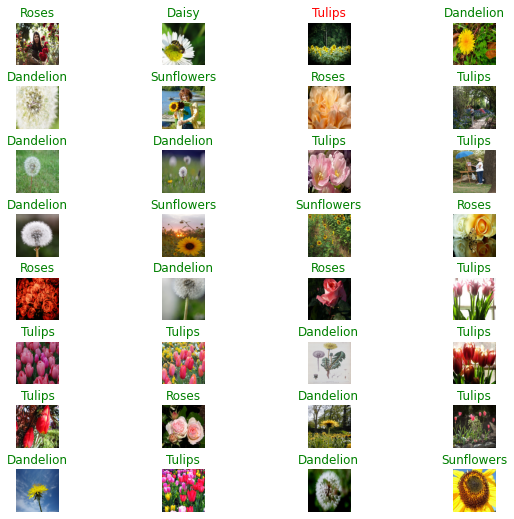

In [88]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(imB[i])
    color = 'green' if p_ids[i] == l_ids[i] else 'red'
    plt.title(pcn[i].title(),color=color)
    plt.axis('off')

### We did not follow the original frlow of Machine Learning here to keep things simple but we should still do testing for losses and validations